# Atmospheric Rivers: explore spatiotemporal relationship with avalanches   

This notebook will import the revised avalanche database table, a reference point layer, and the AR events shapefile. A spatiotemporal relationship between AR events and avalanches is explored based on the parameters set in the first code cell below. This is intended as a demonstration only; a more sophisticated analysis would be required to statistically link AR events with avalanches.

### Methodology:  

For each avalanche event, AR landfall events of a minimum duration occuring within a window prior to the avalanche are retained, with distance to the closest AR recorded. Distances of zero indicate the avalanche occurred within the AR polygon boundary. Attributes of AR duration and strength are joined to the avalanche database table. Any NA values in the resulting table indicate that no AR event occurred within the window prior to the avalanche.  
  
Future correlations could use the AR coastal impact points layer for spatial joins, instead of the AR polygon layer, if desired.

### Usage:  

Run the entire notebook, then skip to the last section to see the resulting "Plotting and Summary" information.
  
_Note: the avalanche database table was revised to remove duplicate events, and to choose the nearest populated place to represent the avalanche location. This allows simple linking to a reference point layer, avoiding manual population of coordinates for avalanche events. This method should not produce appreciable errors when considering the scale of this analysis. If the results table will be further filtered by proximity, consider using a value that respects the spatial ambiguity of both the modeled AR boundaries and the generalized avalanche locations._
  
  





#### Set Parameters:

In [18]:
#window preceding avalanche event to search for landfalling ARs
no_days = 7

#AR duration minimum (in hours)
dur_min = 24

#avalanche to AR distance maximum
dist_max = 500

#### Data Preprocessing:

In [19]:
import pandas as pd
import geopandas as gpd
from datetime import timedelta

from config import landfall_events_shp, ak_pts, avy_db

In [20]:
#read in AK points reference, avalanche db, and AR events shp
ak_pts = pd.read_csv(ak_pts)
avy = pd.read_csv(avy_db, skiprows=1)
ars = gpd.read_file(landfall_events_shp)

In [21]:
#join avalanche db to AK points, clean table for processing, and add geometry using lat/lon info
df = avy.merge(ak_pts, how='left', left_on='Loc', right_on='name')
df['date'] = pd.to_datetime(df['Avalanche Date'])
df.rename(columns={'Avalanche ID (new)' : 'ID'}, inplace=True)
df = df[['ID', 'date', 'Trigger', 'name', 'latitude', 'longitude']]
df['geometry'] = gpd.GeoSeries.from_xy(df['longitude'], df['latitude'], crs=ars.crs)
df = gpd.GeoDataFrame(df, geometry='geometry')

/tmp/ipykernel_28595/107876706.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['Avalanche Date'])


In [22]:
#convert both to 3338 for minimum distance measurement
df_3338 = df.to_crs('EPSG:3338')
ars_3338 = ars.to_crs('EPSG:3338')

#### Temporal filtering:

In [23]:
#create a duration dictionary with AR ids and their start and end dates
ids = ars_3338['event_id']
starts = ars_3338['start']
ends = ars_3338['end']

ars_dict = {i : [s, e] for i, s, e in zip(ids, starts, ends)}


In [24]:
#~2 min, brute force iteration
#for each avalanche ID, create a date range of 1 week preceding the avalanche
#then for each AR in the duration dictionary, compare the AR date range to the avalanche date range
#if overlapping, add the avalanche ID and list of one or more ARs to a new dictionary

avy_ars = {}

for avy in df_3338['ID'].unique():

    #create a range of dates from 1 week before avalanche to avalanche
    avy_end_date = df_3338[df_3338['ID']==avy]['date']
    avy_start_date = avy_end_date - timedelta(days=no_days)

    ars_sub = []

    #check if the avalanche date range overlaps any of the AR ranges
    for k in ars_dict.keys():
        ar_start_date = ars_dict[k][0]
        ar_end_date = ars_dict[k][1]

        #add to list if overlapping
        if (avy_start_date <= ar_end_date).bool() & (ar_start_date <= avy_end_date).bool():
            ars_sub.append(k)

    #if any ARs overlap, add list to dictionary    
    if len(ars_sub) > 0:
        avy_ars[avy] = [ars_sub]

#### Spatial Analysis:

In [25]:
#using the dictionary of ARs occuring within 1 week prior to avalanche, find the AR with minimum distance to the AR
#record the AR id and its distance from avalanche (in km) in a new dict
#distance values of 0 indicate the point is inside the AR polygon
#if more than one AR have the same distance of zero, only the first is retained
 
avy_ars_min_dist = {}

for a in avy_ars:
    pt_a = df_3338.loc[df_3338['ID']==a].geometry

    dists = []

    for b in avy_ars[a][0]:
        pt_b = ars_3338.iloc[[b]].geometry
        dist = pt_a.distance(pt_b, align=False)
        dists.append(round(dist.iloc[0]/1000)) #convert m to km, and round to integer
    
    avy_ars_min_dist[a] = [avy_ars[a][0][pd.Series(dists).idxmin()], dists[pd.Series(dists).idxmin()]]    

In [26]:
#convert minimum distance dict to dataframe and join to original avalanche points
#then join AR properties
result = df_3338.merge(
    pd.DataFrame.from_dict(avy_ars_min_dist, orient='index', columns=['AR_ID', 'min_km']),
     how='left', left_on='ID', right_index=True).merge(
        ars_3338, how='left', left_on='AR_ID', right_on='event_id')

#clean results table
result = result.rename(columns={'ID':'Avalanche_ID',
'date':'Date', 
'name':'Location',
'latitude':'Latitude',
'longitude':'Longitude', 
'AR_ID':'AR_Event_ID', 
'min_km':'Avalanche_to_AR_Distance_km',
'start':'Start',
'end':'End',
'sumtot_str':'Cumulative_AR_Total_Strength',
'sumrel_str':'Cumulative_AR_Relative_Strength'
}).drop(columns=['event_id', 'geometry_x', 'geometry_y'])

In [27]:
result

Avalanche_ID       Date  Trigger     Location  Latitude  Longitude  \
0               5 1988-04-09  Natural    Anchorage   61.1817  -149.9930   
1              18 1992-11-08  Natural    Anchorage   61.1817  -149.9930   
2              20 1993-01-10    Human    Anchorage   61.1817  -149.9930   
3              42 1999-03-26  no data    Anchorage   61.1817  -149.9930   
4              66 2000-11-11    Human    Anchorage   61.1817  -149.9930   
..            ...        ...      ...          ...       ...        ...   
164           128 2010-02-13  no data     Whittier   60.7730  -148.6840   
165           130 2010-02-18  no data   Moose Pass   60.4876  -149.3670   
166           132 2010-05-29  no data  Petersville   62.3730  -150.7332   
167           158 2015-04-01    Human      Chitina   61.5158  -144.4370   
168           174 2017-02-27  no data      Wiseman   67.4100  -150.1070   

     AR_Event_ID  Avalanche_to_AR_Distance_km                Start  \
0            NaN                          NaN                  NaN   
1           47.0                          0.0  1992-11-08 00:00:00   
2           54.0                        935.0  1993-01-03 12:00:00   
3          385.0                        238.0  1999-03-22 06:00:00   
4          480.0                          0.0  2000-11-07 18:00:00   
..           ...                          ...                  ...   
164        986.0                          0.0  2010-02-06 06:00:00   
165        988.0                          0.0  2010-02-16 00:00:00   
166       1002.0                        708.0  2010-05-25 06:00:00   
167       1246.0                        327.0  2015-03-28 18:00:00   
168       1347.0                        139.0  2017-02-25 00:00:00   

                     End  ...  Cumulative_AR_Relative_Strength  ratio_m  \
0                    NaN  ...                              NaN      NaN   
1    1992-11-09 06:00:00  ...                           2690.0      3.0   
2    1993-01-03 18:00:00  ...                            707.0      3.0   
3    1999-03-22 18:00:00  ...                            985.0      4.0   
4    2000-11-11 00:00:00  ...                           3772.0      2.0   
..                   ...  ...                              ...      ...   
164  2010-02-06 12:00:00  ...                            562.0      6.0   
165  2010-02-18 12:00:00  ...                           2429.0      4.0   
166  2010-05-25 06:00:00  ...                            286.0      4.0   
167  2015-03-28 18:00:00  ...                            456.0      2.0   
168  2017-02-26 06:00:00  ...                           1074.0      3.0   

     len_km_m  orient_m  poleward_m  dircoher_m  mean_dir_m  dur_hrs  \
0         NaN       NaN         NaN         NaN         NaN      NaN   
1      2772.0      23.0       236.0        78.0       358.0     36.0   
2      2649.0     341.0       288.0        66.0       350.0     12.0   
3      3228.0     354.0       257.0        89.0       357.0     18.0   
4      2719.0      18.0       246.0        80.0       358.0     84.0   
..        ...       ...         ...         ...         ...      ...   
164    2440.0     328.0       300.0        86.0       358.0     12.0   
165    3706.0     347.0       276.0        81.0         2.0     66.0   
166    2557.0     329.0       307.0        90.0       358.0      6.0   
167    3673.0      33.0       238.0        91.0       356.0      6.0   
168    2175.0      34.0       222.0        74.0         6.0     36.0   

     tintensity  rintensity  
0           NaN         NaN  
1      221129.0        75.0  
2      180599.0        59.0  
3       54949.0        55.0  
4       98546.0        45.0  
..          ...         ...  
164     62390.0        47.0  
165    119349.0        37.0  
166     31694.0        48.0  
167    186769.0        76.0  
168    100369.0        30.0  

[169 rows x 21 columns]

#### Plotting and Summary:

In [28]:
print("There are " + str(len(df_3338['ID'].unique())) + " unique avalanche events in the revised database...")
print("There are " + str(len(result[(~result['AR_Event_ID'].isna())])) + " avalanches having at least one landfalling AR event occuring within the " + str(no_days) + " days preceding the avalanche event...")
print("\n")

print("If considering only those linked events...")
print("There are " + str(len((result[(result['dur_hrs'] >= dur_min)]))) + " AR events lasting " + str(dur_min) + " hours or longer...")
print("There are " + str(len(result[(~result['AR_Event_ID'].isna()) & (result['Trigger'] != 'Human')])) + " avalanche events not known to be triggered by humans...")
print("There are " + str(len(result[(~result['AR_Event_ID'].isna()) & (result['Avalanche_to_AR_Distance_km'] < dist_max)])) + " avalanche events within " + str(dist_max) + "km of the AR polygon...")
print("\n")

print("There are " + str(len(result[(~result['AR_Event_ID'].isna()) & (result['dur_hrs'] >= dur_min) & (result['Trigger'] != 'Human') & (result['Avalanche_to_AR_Distance_km'] < dist_max)])) + " events meeting all three criteria above. This subset is plotted below...")


There are 169 unique avalanche events in the revised database...
There are 142 avalanches having at least one landfalling AR event occuring within the 7 days preceding the avalanche event...


If considering only those linked events...
There are 87 AR events lasting 24 hours or longer...
There are 98 avalanche events not known to be triggered by humans...
There are 110 avalanche events within 500km of the AR polygon...


There are 57 events meeting all three criteria above. This subset is plotted below...


<Axes: xlabel='Date', ylabel='rintensity'>

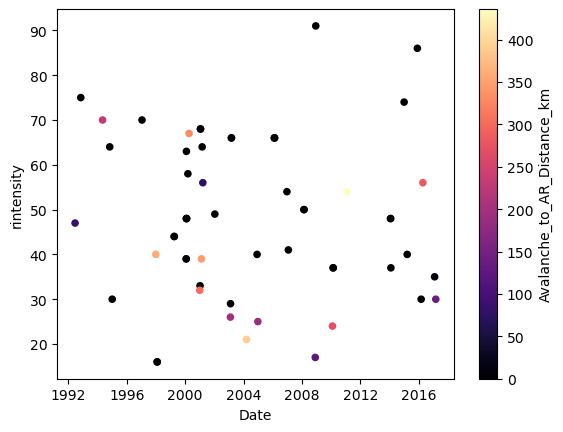

In [29]:
# plot intensity over time, with distance for context
result[(~result['AR_Event_ID'].isna()) & 
(result['dur_hrs'] >= dur_min) & 
(result['Trigger'] != 'Human') & 
(result['Avalanche_to_AR_Distance_km'] < dist_max)].plot.scatter('Date', 'rintensity', c='Avalanche_to_AR_Distance_km', colormap='magma')


_If using default parameters of 7 day window, 24 hour duration, and 500km distance...._

We see the vast majority of linked avalanche/AR events have a zero distance (ie, the modeled AR polygon overlaps the approximate avalanche location). Excluding events using a smaller distance threshold (eg, 200km) would not appear to affect the analysis very much. 

There is no obvious trend of intensity or distance over time, though the extremes of the intensity values could be explored in relation to cyclic atmospheric phenomena.